In [1]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


# Pequeño preprocesado

In [2]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import nltk

In [3]:
# Cargar datos
descripciones_df = pd.read_csv("steam_descripciones_juegos.csv")
reseñas_df = pd.read_csv("steam_reseñas.csv")

# Unir los títulos únicos por 'game_id'
titulos_unicos = reseñas_df[['game_id', 'game_title']].drop_duplicates(subset='game_id')
juegos_df = descripciones_df.merge(titulos_unicos, on='game_id', how='left')

In [4]:
juegos_df.head()

,game_id,game_description,genres,categories,clean_text,lemmatized_text,game_title
0,578080,"ATERRIZA, Aterriza en una selecc...","['Acción', 'Aventura', 'Multijugador masivo', ...","['Multijugador', 'JcJ', 'JcJ en línea', 'Estad...",aterriza aterriza seleccion mapas constantes c...,aterrizar aterriza seleccion mapa constante ca...,PUBG: BATTLEGROUNDS
1,730,"Durante las dos últimas décadas, Counter‑Strik...","['Acción', 'Free to Play']","['Multijugador', 'Multijugador multiplataforma...",dos ultimas decadas counter-strike proporciona...,dos ultima decada counter-strike proporcionado...,Counter-Strike 2
2,3017860,PREMIUM EDITION Resiste las acometidas y l...,['Acción'],"['Un jugador', 'Logros de Steam', 'Compat. tot...",premium edition resiste acometidas lucha edici...,premium edition resistir acometido lucha edici...,DOOM: The Dark Ages
3,1091500,Cyberpunk 2077: Ultimate Edition Descubr...,['Rol'],"['Un jugador', 'Logros de Steam', 'Compat. tot...",cyberpunk 2077 ultimate edition descubre juego...,cyberpunk 2077 ultimate edition descubrir jueg...,Cyberpunk 2077
4,553850,Digital Deluxe Edition La edición incluye...,['Acción'],"['Multijugador', 'Cooperativo', 'Cooperativo e...",digital deluxe edition edicion incluye conjunt...,digital deluxe edition edicion incluir conjunt...,HELLDIVERS™ 2


In [5]:
juegos_df.isna().sum()

game_id             0
game_description    0
genres              0
categories          0
clean_text          3
lemmatized_text     3
game_title          0
dtype: int64

In [6]:
# Filtrar juegos con clean_text NaN
juegos_con_nan = juegos_df[juegos_df['clean_text'].isna()]

# Mostrar sus títulos y IDs
print(juegos_con_nan[['game_description']])

    game_description
10                  
17                  
162                 


In [7]:
juegos_df=juegos_df.dropna()

In [8]:
juegos_df.isna().sum()

game_id             0
game_description    0
genres              0
categories          0
clean_text          0
lemmatized_text     0
game_title          0
dtype: int64

In [9]:
# Limpiar campos y preparar texto combinado
def combinar_texto(row):
    descripcion = str(row['clean_text'])
    generos = " ".join(eval(row['genres'])) if pd.notnull(row['genres']) else ""
    categorias = " ".join(eval(row['categories'])) if pd.notnull(row['categories']) else ""
    return f"{descripcion} {generos} {categorias}"

juegos_df['texto_completo'] = juegos_df.apply(combinar_texto, axis=1)
juegos_df['game_title'] = juegos_df['game_title'].str.lower()  

In [10]:
juegos_df.head()

,game_id,game_description,genres,categories,clean_text,lemmatized_text,game_title,texto_completo
0,578080,"ATERRIZA, Aterriza en una selecc...","['Acción', 'Aventura', 'Multijugador masivo', ...","['Multijugador', 'JcJ', 'JcJ en línea', 'Estad...",aterriza aterriza seleccion mapas constantes c...,aterrizar aterriza seleccion mapa constante ca...,pubg: battlegrounds,aterriza aterriza seleccion mapas constantes c...
1,730,"Durante las dos últimas décadas, Counter‑Strik...","['Acción', 'Free to Play']","['Multijugador', 'Multijugador multiplataforma...",dos ultimas decadas counter-strike proporciona...,dos ultima decada counter-strike proporcionado...,counter-strike 2,dos ultimas decadas counter-strike proporciona...
2,3017860,PREMIUM EDITION Resiste las acometidas y l...,['Acción'],"['Un jugador', 'Logros de Steam', 'Compat. tot...",premium edition resiste acometidas lucha edici...,premium edition resistir acometido lucha edici...,doom: the dark ages,premium edition resiste acometidas lucha edici...
3,1091500,Cyberpunk 2077: Ultimate Edition Descubr...,['Rol'],"['Un jugador', 'Logros de Steam', 'Compat. tot...",cyberpunk 2077 ultimate edition descubre juego...,cyberpunk 2077 ultimate edition descubrir jueg...,cyberpunk 2077,cyberpunk 2077 ultimate edition descubre juego...
4,553850,Digital Deluxe Edition La edición incluye...,['Acción'],"['Multijugador', 'Cooperativo', 'Cooperativo e...",digital deluxe edition edicion incluye conjunt...,digital deluxe edition edicion incluir conjunt...,helldivers™ 2,digital deluxe edition edicion incluye conjunt...


# Enfoque con el texto concatenado con el género y las categorías 

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_es = stopwords.words('spanish')
vectorizer = TfidfVectorizer(stop_words=stopwords_es, max_features=10000)
tfidf_matrix = vectorizer.fit_transform(juegos_df['texto_completo'])

# Calcular similitud coseno
similitud_coseno = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Guardar nombres de los juegos (por índice)
indices_juegos = pd.Series(juegos_df.index, index=juegos_df['game_title'].fillna("Desconocido")).drop_duplicates()

# Función de recomendación
def recomendar_juegos(nombre_juego, top_n=5):
    nombre_juego = nombre_juego.lower()
    if nombre_juego not in indices_juegos:
        return f"No se encontró el juego '{nombre_juego}'."
    
    idx = indices_juegos[nombre_juego]
    similitudes = list(enumerate(similitud_coseno[idx]))
    similitudes = sorted(similitudes, key=lambda x: x[1], reverse=True)[1:top_n+1]
    juegos_recomendados = [juegos_df.iloc[i[0]]['game_title'] for i in similitudes]
    
    return juegos_recomendados

# Ejemplo
print(recomendar_juegos("PUBG: BATTLEGROUNDS"))

['risk of rain 2', 'naraka: bladepoint', 'battlefield 4™', 'throne and liberty', 'world of tanks']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noelg02/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg

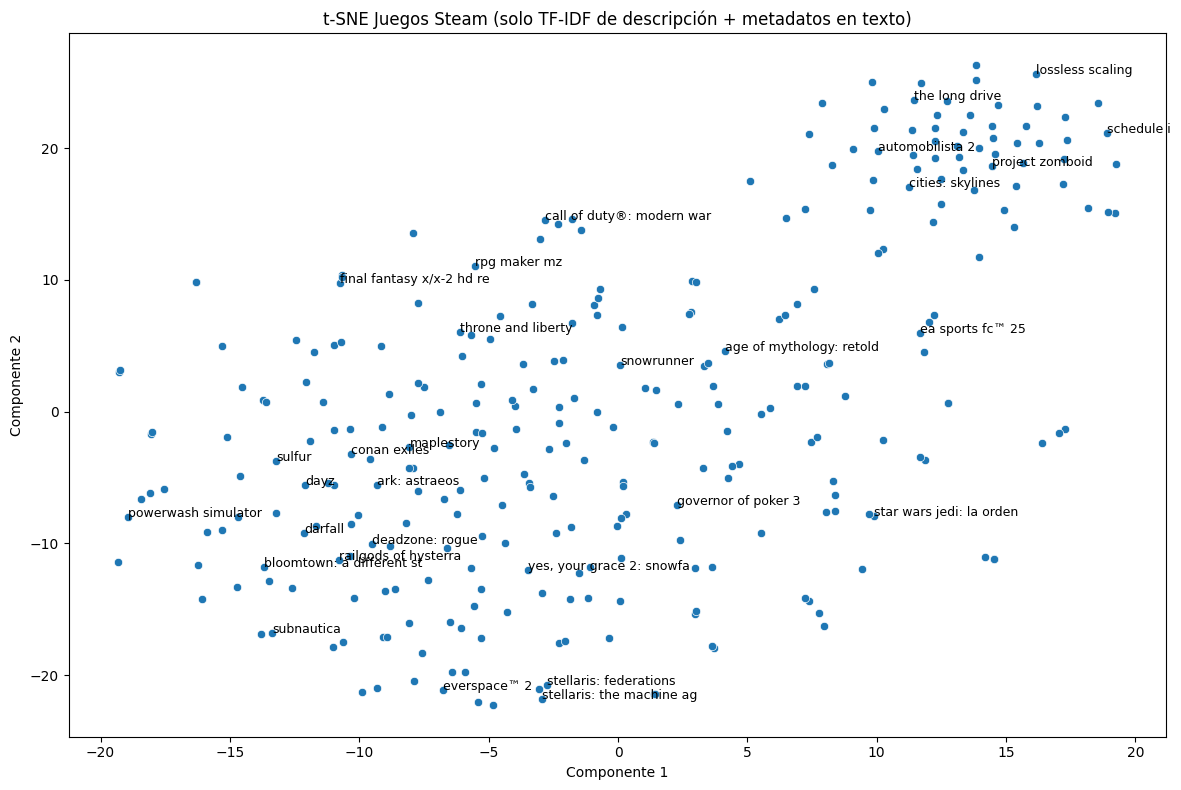

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Selección de muestra para visualización
sample_size = 300
np.random.seed(42)
sample_indices = np.random.choice(tfidf_matrix.shape[0], size=sample_size, replace=False)

# Aplicar t-SNE sobre los vectores TF-IDF
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_tsne = tsne.fit_transform(tfidf_matrix[sample_indices].toarray())

# Preparar títulos truncados para visualización
sample_titles = juegos_df.iloc[sample_indices]['game_title'].fillna("Desconocido").str[:25]

# Visualizar con seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_tsne[:, 0], y=reduced_tsne[:, 1])
for i in range(0, sample_size, 10):  # etiquetas cada 30 puntos
    plt.text(reduced_tsne[i, 0], reduced_tsne[i, 1], sample_titles.iloc[i], fontsize=9)

plt.title("t-SNE Juegos Steam (solo TF-IDF de descripción + metadatos en texto)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.tight_layout()
plt.show()

# Enfoque empleando el texto, las categorías y los géneros por separado

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import nltk

# 1. TF-IDF sobre 'clean_text'
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_es = stopwords.words('spanish')

vectorizer_text = TfidfVectorizer(stop_words=stopwords_es, max_features=5000)
tfidf_text = vectorizer_text.fit_transform(juegos_df['clean_text'])

# 2. One-hot encoding para 'genres' y 'categories'
mlb_genres = MultiLabelBinarizer()
mlb_categories = MultiLabelBinarizer()

# Convierte de string a listas
juegos_df.loc[:, 'genres_list'] = juegos_df['genres'].apply(lambda x: eval(x) if pd.notnull(x) else [])
juegos_df.loc[:, 'categories_list'] = juegos_df['categories'].apply(lambda x: eval(x) if pd.notnull(x) else [])


genres_encoded = mlb_genres.fit_transform(juegos_df['genres_list'])
categories_encoded = mlb_categories.fit_transform(juegos_df['categories_list'])

# 3. Concatenar los vectores
from scipy.sparse import csr_matrix
combined_features = hstack([tfidf_text, csr_matrix(genres_encoded), csr_matrix(categories_encoded)])

# 4. Calcular similitud coseno
similitud_coseno = cosine_similarity(combined_features, combined_features)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noelg02/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg

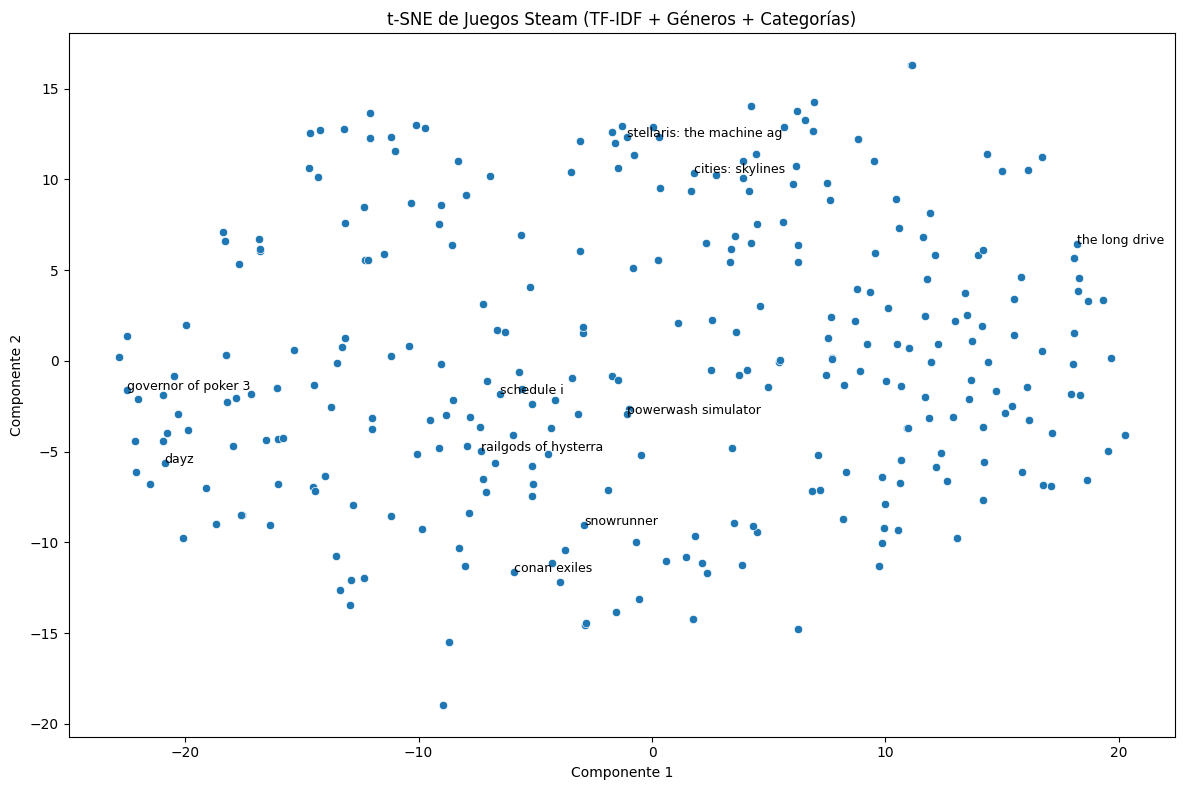

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reducimos la dimensionalidad con t-SNE
sample_size = 300  # puedes ajustarlo para más juegos
np.random.seed(42)
sample_indices = np.random.choice(combined_features.shape[0], size=sample_size, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_tsne = tsne.fit_transform(combined_features[sample_indices].toarray())

# Preparamos los títulos recortados para visualización
sample_titles = juegos_df.iloc[sample_indices]['game_title'].fillna("Desconocido").str[:25]

# Visualización
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_tsne[:, 0], y=reduced_tsne[:, 1])
for i in range(0, sample_size, 30):  # muestra algunos nombres cada N puntos
    plt.text(reduced_tsne[i, 0], reduced_tsne[i, 1], sample_titles.iloc[i], fontsize=9)
plt.title("t-SNE de Juegos Steam (TF-IDF + Géneros + Categorías)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.tight_layout()
plt.show()


En vista de los dos resultados se decide proceder con el primer método.

# Creación de la app de streamlit con el chatbot de mixtral

Instalamos esta librería para poder ver las barras al cargar el modelo y luego otras dos típicas empleadas por modelos como Mixtral.

In [15]:
%pip install -U jupyter ipywidgets
%pip install sentencepiece protobuf

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from huggingface_hub import login
login("hf_XXXXXX")  # Reemplazar con el mio pero no se puede subir a github

In [17]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto", use_auth_token=True)


/Users/noelg02/venvs/steam/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:898: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the disk.
